In [1]:
import sys
sys.path.append('/gpfs/loomis/home.grace/ys668/software/koza4ok')
import uproot4 as uproot
import math
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, precision_recall_curve, plot_precision_recall_curve
from skTMVA import convert_bdt_sklearn_tmva
from joblib import dump, load
import pickle

In [2]:
tree = uproot.open( "/gpfs/loomis/home.grace/ys668/output/mltree1.root:Stg" )

In [3]:
xyztv = tree.arrays( [ "x", "y", "z", "tid", "vid" ], library='np')

In [37]:
class HitPoint:
    def __init__( self, _x, _y, _z, _v, _t, _p ):
        self.x = _x
        self.y = _y
        self.z = _z
        self.v = _v
        self.t = _t
        self.p = _p
    def __repr__( self ):
        return 'HitPoint[v=%d, (%0.3f, %0.3f, %0.3f), tid=%d]' % ( self.v, self.x, self.y, self.z, self.t, self.p )
    
class CriteriaResult:
    def __init__(self):
        self.real = False
        self.res = -99
        self.pt = -99
        self.eta = -99
        self.phi = -99
    
        
def generate_vol_map( x, y, z, v, t, phi0, phi1 ):
    vol_map = [ [], [], [], [] ] # maps to 4 volumes
    interval = phi1 - phi0
    for _x, _y, _z, _v, _t in zip(  x, y, z, v, t ):
        phi = math.atan2( _y, _x )      
        for i in range(0, int(2*np.pi/interval)):
            if phi < phi1+i*interval and phi >= phi0+i*interval :
                vol_map[_v].append( HitPoint( _x, _y, _z, _v, _t, phi0+i*interval ) )
    return vol_map

def gen_pairs( vm ) :
    hp = []
    for i in np.arange( 0, 3 ):
        for a in vm[i] :
            for b in vm[i+1]:
                if a.p == b.p:
                    hp.append( (a,b) )
    return hp

def loc(a, b):
    return[a.x, a.y, a.z, b.x, b.y, b.z]

def crit_rz( a, b ):
    dx = a.x-b.x
    dy = a.y-b.y
    dz = a.z-b.z
    return (dx**2+dy**2+dz**2)/dz**2;

M_PI = 3.1415926
def crit_dphi( a, b ):
    phia = math.atan2( a.y, a.x )
    phib = math.atan2(b.y, b.x)
    deltaPhi = phia-phib
    if deltaPhi > M_PI :
        deltaPhi = deltaPhi - 2*M_PI
    if deltaPhi < -M_PI:
        deltaPhi = deltaPhi + 2*M_PI
    if ( b.y*b.y + b.x*b.x < 0.0001 ) or ( a.y*a.y + a.x*a.x < 0.0001 ):
        deltaPhi = 0
    deltaPhi = 180. * math.fabs( deltaPhi ) / M_PI
    return deltaPhi

def crit_deltaRho( a, b ):
    rhoA =  math.sqrt( a.x*a.x + a.y*a.y );
    rhoB =  math.sqrt( b.x*b.x + b.y*b.y );

    deltaRho = rhoA - rhoB;
    return deltaRho

def crit_straightTrackRatio( a, b ):
    rhoA =  math.sqrt( a.x*a.x + a.y*a.y );
    rhoB =  math.sqrt( b.x*b.x + b.y*b.y );
    
    ratio = (rhoA*b.z) / (rhoB*a.z)
    return ratio

In [38]:
all_pairs = []
real_pairs = []
fake_pairs = []

all_RZ = []
all_DP = []
all_DR = []
all_SR = []

for iEvent in np.arange( len(xyztv["x"]) ) :
    vm = generate_vol_map( xyztv["x"][iEvent], xyztv["y"][iEvent], xyztv["z"][iEvent], xyztv["vid"][iEvent], xyztv["tid"][iEvent], 0, math.pi/4 )
    pairs = gen_pairs( vm )
    all_pairs.extend( pairs )

In [39]:
print(len(all_pairs))

4547177


In [40]:
all_RZ = [ crit_rz( p[0], p[1] ) for p in all_pairs ]
all_DP = [ crit_dphi( p[0], p[1] ) for p in all_pairs ]
all_DR = [ crit_deltaRho( p[0], p[1] ) for p in all_pairs ]
all_SR = [ crit_straightTrackRatio( p[0], p[1] ) for p in all_pairs ]

In [42]:
print(all_RZ[:4])
print(all_DP[:4])
print(all_DR[:4])
print(all_SR[:4])

[1.0057341878052604, 1.0322915810058668, 1.1530884871424862, 1.1519700991115578]
[0.11329639004960716, 0.9640623108866178, 17.682524125875894, 19.261573371424536]
[-1.7258542876287102, -4.076738479739401, -4.7483425245546655, -3.277197792195583]
[1.0066438469235277, 0.9141166925439486, 0.8914264734279581, 0.9468788794472899]


In [9]:
realtrack = [ True if p[0].t == p[1].t else False for p in all_pairs ]
RZ_real = [ rz for i, rz in enumerate(all_RZ) if all_pairs[i][0].t == all_pairs[i][1].t  ]
RZ_fake = [ rz for i, rz in enumerate(all_RZ) if all_pairs[i][0].t != all_pairs[i][1].t  ]
DP_real = [ rz for i, rz in enumerate(all_DP) if all_pairs[i][0].t == all_pairs[i][1].t  ]
DP_fake = [ rz for i, rz in enumerate(all_DP) if all_pairs[i][0].t != all_pairs[i][1].t  ]
DR_real = [ rz for i, rz in enumerate(all_DR) if all_pairs[i][0].t == all_pairs[i][1].t  ]
DR_fake = [ rz for i, rz in enumerate(all_DR) if all_pairs[i][0].t != all_pairs[i][1].t  ]
SR_real = [ rz for i, rz in enumerate(all_SR) if all_pairs[i][0].t == all_pairs[i][1].t  ]
SR_fake = [ rz for i, rz in enumerate(all_SR) if all_pairs[i][0].t != all_pairs[i][1].t  ]

In [14]:
real = [RZ_real, DP_real, DR_real, SR_real]
fake = [RZ_fake, DP_fake, DR_fake, SR_fake]

In [16]:
realt = np.transpose(real)
faket = np.transpose(fake)

In [13]:
print(realt[0])
print(RZ_real[0], DP_real[0], DR_real[0], SR_real[0])

[ 1.00398141  0.08962194 -1.43836398  0.99871486]
1.003981412470476 0.08962193899695364 -1.4383639827074148 0.9987148571460467


In [17]:
X2 = np.concatenate((realt, faket))
y2 = np.concatenate((np.ones(len(realt)), np.zeros(len(faket))))

In [24]:
print(len(X2))

848610


In [18]:
X2_dev,X2_eval, y2_dev,y2_eval = train_test_split(X2, y2, test_size=0.33, random_state=42)
X2_train,X2_test, y2_train,y2_test = train_test_split(X2_dev, y2_dev, test_size=0.33, random_state=492)

In [19]:
dt = DecisionTreeClassifier(max_depth=3)
bdt2 = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt2.fit(X2_train, y2_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.5, n_estimators=800)

In [20]:
filename = 'bdt2_crit2.sav'
pickle.dump(bdt2, open(filename, 'wb'))

In [21]:
y2_predicted = bdt2.predict(X2_test)
print (classification_report(y2_test, y2_predicted,
                            target_names=["fake", "real"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y2_test,
                                                  bdt2.decision_function(X2_test))))

              precision    recall  f1-score   support

        fake       0.91      0.94      0.93    148261
        real       0.75      0.64      0.69     39367

    accuracy                           0.88    187628
   macro avg       0.83      0.79      0.81    187628
weighted avg       0.88      0.88      0.88    187628

Area under ROC curve: 0.9232


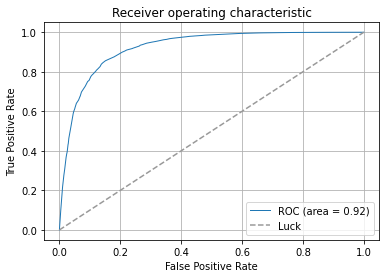

In [22]:
decisions = bdt2.decision_function(X2_test)
fpr, tpr, thresholds = roc_curve(y2_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

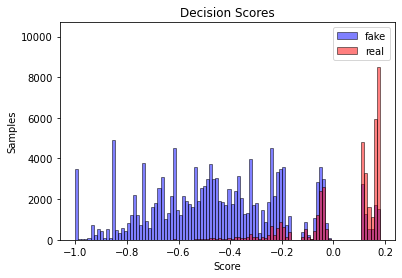

In [23]:
plot_colors = "br"
plot_step = 0.02
class_names = 'fake','real'

plot_range = (decisions.min(), decisions.max())
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(decisions[y2_test == i],
             bins=100,
             range=plot_range,
             facecolor=c,
             label=n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.show()